# Exp-03: Prompt Engineering & Answer Generation Optimization
- **Date**: 2026-02-09
- **Prerequisite**: EXP01 (chunk=500, layout) + EXP02 (alpha=0.3, top_k=15)
- **Goal**: RAG 프롬프트 전략별 답변 품질 비교 및 최적 프롬프트 선정
- **Focus**: Faithfulness(환각 방지) + Answer Correctness(정답 정확도) 최대화

## 변경 이력
- v1: 4가지 프롬프트 전략 비교 실험

## 1. 실험 설계 (Experiment Design)

### 1.1 실험 배경
EXP01~02에서 **검색(Retrieval)** 파이프라인을 최적화했습니다:
- EXP01: chunk=500, layout (Context Recall 0.7333)
- EXP02: alpha=0.3, top_k=15 (Recall 0.7333~0.7667)

EXP03에서는 검색 설정을 고정하고, **생성(Generation)** 단계의 프롬프트를 최적화합니다.

### 1.2 변수 (Variables)
- **Independent (실험군)**: Prompt Strategy
  - `zero_shot_en`: 영문 기본 프롬프트 (현재 RAGChain 기본값)
  - `zero_shot_ko`: 한국어 도메인 특화 프롬프트
  - `few_shot_ko`: 한국어 + Few-shot 예시 2개
  - `cot_ko`: 한국어 + Chain-of-Thought 추론 유도
- **Controlled (통제 변수)** — EXP01+02 최적 설정 고정:
  - Chunk Size: 500, Table Strategy: layout
  - Alpha: 0.3, Top-K: 15
  - LLM: gpt-5-mini

### 1.3 가설 (Hypothesis)
1. 한국어 RFP 문서에 한국어 프롬프트(`zero_shot_ko`)가 영문(`zero_shot_en`)보다 정확할 것이다.
2. Few-shot 예시를 추가하면 답변 형식의 일관성이 개선될 것이다.
3. CoT는 복잡한 질문(hard)에서 유리하지만, 쉬운 질문에서는 오히려 과도한 추론을 유발할 수 있다.

### 1.4 메트릭 (Metrics)
- **Faithfulness** (primary): 답변이 검색된 문맥에 근거하는 비율 (환각 방지)
- **Answer Relevancy**: 답변이 질문에 적절히 대응하는 정도
- **Answer Correctness**: 답변이 Ground Truth와 일치하는 정도
- **Keyword Accuracy** (custom, LLM-free): Ground Truth 키워드 포함 비율

## 2. 환경 설정 (Setup)

In [1]:
import sys
import os
import time
import gc
import json
import shutil
import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from collections import defaultdict

from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_community.retrievers import BM25Retriever

from bidflow.parsing.pdf_parser import PDFParser
from bidflow.eval.ragas_runner import RagasRunner, FixedTempChatOpenAI

%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print('[System] 모듈 로드 완료')

[System] 모듈 로드 완료


## 3. 데이터 로드 및 인덱스 구축
EXP01+02 최적 설정으로 인덱스를 구축하고, **검색을 1회 수행**하여 모든 프롬프트 전략에 동일한 context를 제공합니다.

In [2]:
# ===== 경로 설정 =====
DATA_DIR = '../data/raw/files'
GOLDEN_TESTSET_PATH = '../data/experiments/golden_testset.csv'
CHROMA_EXP_PATH = '../data/chroma_exp/exp03'
EXP02_REPORT_PATH = '../data/experiments/exp02_report.json'

# ===== EXP01+02 최적 설정 (통제 변수) =====
CHUNK_SIZE = 500
TABLE_STRATEGY = 'layout'
CHUNK_OVERLAP = 50
ALPHA = 0.3        # EXP02 Best
TOP_K = 15         # EXP02 Best

# ===== 1. EXP02 결과 확인 =====
print('=' * 60)
print('1. EXP02 결과 확인 (Prerequisite)')
print('=' * 60)

EXP02_RECALL = 0.7333
if os.path.exists(EXP02_REPORT_PATH):
    with open(EXP02_REPORT_PATH, 'r', encoding='utf-8') as f:
        exp02 = json.load(f)
    best = exp02['best_config']
    EXP02_RECALL = best['context_recall']
    print(f"[OK] EXP02 Best: alpha={best['alpha']}, "
          f"top_k={best['top_k']}, recall={best['context_recall']:.4f}")
else:
    print('[Warning] EXP02 리포트 없음. 기본값 사용.')

# ===== 2. Golden Testset 로드 =====
print('\n' + '=' * 60)
print('2. Golden Testset 로드')
print('=' * 60)

TESTSET_READY = False
if os.path.exists(GOLDEN_TESTSET_PATH):
    golden_df = pd.read_csv(GOLDEN_TESTSET_PATH)
    golden_df = golden_df[~golden_df['ground_truth'].str.contains(r'\[여기에', na=False)]
    if len(golden_df) > 0:
        print(f'[OK] {len(golden_df)}개 테스트 케이스 로드됨')
        TESTSET_READY = True
    else:
        print('[Error] Golden Testset이 비어있습니다!')
else:
    print(f'[Error] Golden Testset 파일이 없습니다.')

# ===== 3. 샘플 PDF =====
print('\n' + '=' * 60)
print('3. 샘플 PDF 파일 검색')
print('=' * 60)

SAMPLE_FILE = None
if os.path.exists(DATA_DIR):
    pdfs = [f for f in os.listdir(DATA_DIR) if f.lower().endswith('.pdf')]
    if pdfs:
        SAMPLE_FILE = os.path.join(DATA_DIR, pdfs[0])
        print(f'[OK] 샘플 PDF: {pdfs[0]}')

results = []

1. EXP02 결과 확인 (Prerequisite)
[OK] EXP02 Best: alpha=0.5, top_k=15, recall=0.7667

2. Golden Testset 로드
[OK] 30개 테스트 케이스 로드됨

3. 샘플 PDF 파일 검색
[OK] 샘플 PDF: 고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf


In [3]:
def robust_rmtree(path):
    if not os.path.exists(path): return
    for _ in range(5):
        try: shutil.rmtree(path); return
        except PermissionError: gc.collect(); time.sleep(1)
        except Exception: return

def rrf_merge(bm25_docs, vector_docs, w_bm25, w_vector, top_k, k=60):
    """Weighted RRF (EXP02와 동일)"""
    scores = defaultdict(float)
    doc_map = {}
    for rank, doc in enumerate(bm25_docs):
        scores[doc.page_content] += w_bm25 * (1 / (rank + k))
        doc_map[doc.page_content] = doc
    for rank, doc in enumerate(vector_docs):
        scores[doc.page_content] += w_vector * (1 / (rank + k))
        if doc.page_content not in doc_map:
            doc_map[doc.page_content] = doc
    sorted_contents = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
    return [doc_map[c] for c in sorted_contents[:top_k]]


INDEX_READY = False
pre_retrieved = []  # (question, ground_truth, contexts) 저장

if SAMPLE_FILE and TESTSET_READY:
    # --- 인덱스 구축 ---
    print('=' * 60)
    print(f'인덱스 구축: chunk={CHUNK_SIZE}, table={TABLE_STRATEGY}')
    print('=' * 60)

    robust_rmtree(CHROMA_EXP_PATH)
    os.makedirs(CHROMA_EXP_PATH, exist_ok=True)

    parser = PDFParser()
    chunks = parser.parse(SAMPLE_FILE, chunk_size=CHUNK_SIZE,
                          chunk_overlap=CHUNK_OVERLAP, table_strategy=TABLE_STRATEGY)
    print(f'  파싱: {len(chunks)}개 청크')

    all_lc_docs = [Document(page_content=c.text,
                            metadata={'chunk_id': c.chunk_id, 'page': c.page_no})
                   for c in chunks]

    embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
    vector_db = Chroma(persist_directory=CHROMA_EXP_PATH,
                       embedding_function=embeddings,
                       collection_name='exp03_prompt')
    vector_db.add_documents(all_lc_docs)
    print('  Vector 인덱싱 완료')

    # --- 사전 검색 (1회, 모든 전략에 동일 context 제공) ---
    print('\n' + '=' * 60)
    print(f'사전 검색: alpha={ALPHA}, top_k={TOP_K}')
    print('=' * 60)

    vector_retriever = vector_db.as_retriever(search_kwargs={'k': TOP_K * 2})
    bm25_retriever = BM25Retriever.from_documents(all_lc_docs)
    bm25_retriever.k = TOP_K * 2

    for _, row in golden_df.iterrows():
        q = row['question']
        gt = str(row['ground_truth'])
        bm25_docs = bm25_retriever.invoke(q)
        vector_docs = vector_retriever.invoke(q)
        retrieved = rrf_merge(bm25_docs, vector_docs,
                              w_bm25=ALPHA, w_vector=1.0-ALPHA, top_k=TOP_K)
        contexts = [doc.page_content for doc in retrieved]
        pre_retrieved.append({'question': q, 'ground_truth': gt,
                              'contexts': contexts,
                              'category': row.get('category', ''),
                              'difficulty': row.get('difficulty', '')})

    print(f'[OK] {len(pre_retrieved)}개 질문 사전 검색 완료')
    INDEX_READY = True
else:
    print('[Error] 데이터 준비 실패')

인덱스 구축: chunk=500, table=layout
  파싱: 611개 청크
  Vector 인덱싱 완료

사전 검색: alpha=0.3, top_k=15
[OK] 30개 질문 사전 검색 완료


## 4. 프롬프트 전략 정의 (Prompt Templates)
4가지 전략을 비교합니다. 검색 결과(context)는 동일하며, 프롬프트만 변경합니다.

In [4]:
PROMPT_STRATEGIES = {
    'zero_shot_en': (
        'Baseline (영문 Zero-shot)',
        """Answer the question based only on the following context:

{context}

Question: {question}

Answer:"""
    ),

    'zero_shot_ko': (
        '한국어 Zero-shot',
        """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 규칙
- 문맥에 없는 정보는 절대 추측하지 말고 "확인 불가"라고 답하세요.
- 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.
- 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변"""
    ),

    'few_shot_ko': (
        '한국어 Few-shot (2 examples)',
        """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 규칙
- 문맥에 없는 정보는 절대 추측하지 말고 "확인 불가"라고 답하세요.
- 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.
- 답변은 간결하게 핵심만 적으세요.

## 답변 예시
질문: 발주 기관은 어디인가?
답변: 고려대학교

질문: 제안서 분량 제한이 있는가?
답변: 확인 불가

## 문맥
{context}

## 질문
{question}

## 답변"""
    ),

    'cot_ko': (
        '한국어 Chain-of-Thought',
        """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 규칙
- 문맥에 없는 정보는 절대 추측하지 말고 "확인 불가"라고 답하세요.
- 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.

## 사고 과정
1. 질문이 요구하는 핵심 정보가 무엇인지 파악하세요.
2. 문맥에서 해당 정보가 포함된 부분을 찾으세요.
3. 찾은 정보를 바탕으로 간결하게 답변하세요.
4. 정보를 찾을 수 없으면 "확인 불가"라고 답하세요.

## 문맥
{context}

## 질문
{question}

## 단계별 분석 후 최종 답변"""
    ),
}

print(f'[OK] {len(PROMPT_STRATEGIES)}개 프롬프트 전략 정의 완료')
for key, (desc, _) in PROMPT_STRATEGIES.items():
    print(f'  - {key}: {desc}')

[OK] 4개 프롬프트 전략 정의 완료
  - zero_shot_en: Baseline (영문 Zero-shot)
  - zero_shot_ko: 한국어 Zero-shot
  - few_shot_ko: 한국어 Few-shot (2 examples)
  - cot_ko: 한국어 Chain-of-Thought


## 5. 평가 함수 및 실험 실행

In [5]:
def calculate_keyword_accuracy(answers, ground_truths, threshold=0.4):
    """
    LLM 호출 없이 키워드 매칭으로 답변 정확도 근사치 계산
    ground_truth 키워드의 threshold 이상이 answer에 포함되면 correct
    """
    scores = []
    for answer, gt in zip(answers, ground_truths):
        gt_words = [w for w in gt.lower().split() if len(w) > 1]
        if not gt_words:
            scores.append(0.0)
            continue
        answer_lower = answer.lower()
        matched = sum(1 for w in gt_words if w in answer_lower)
        scores.append(matched / len(gt_words))
    return float(np.mean(scores))


def extract_metric(val):
    if isinstance(val, (list, tuple)): return float(np.mean(val))
    elif hasattr(val, 'mean'): return float(val.mean())
    else: return float(val) if val is not None else 0.0


print('[OK] 평가 함수 정의 완료')

[OK] 평가 함수 정의 완료


In [6]:
def run_single_experiment(strategy_key, strategy_desc, prompt_template, pre_retrieved):
    """
    단일 프롬프트 전략에 대해 답변 생성 + 평가 수행
    """
    print(f'\n{"="*60}')
    print(f'[Experiment] {strategy_key}: {strategy_desc}')
    print(f'{"="*60}')

    start_time = time.perf_counter()

    # 1. LLM 및 프롬프트 체인 구성
    llm = FixedTempChatOpenAI(model='gpt-5-mini', timeout=180, max_retries=3)
    prompt = ChatPromptTemplate.from_template(prompt_template)
    chain = prompt | llm | StrOutputParser()

    # 2. 모든 질문에 대해 답변 생성
    questions = []
    ground_truths = []
    contexts_list = []
    answers = []

    for item in pre_retrieved:
        q = item['question']
        gt = item['ground_truth']
        ctx = item['contexts']
        context_text = '\n\n'.join(ctx)

        try:
            answer = chain.invoke({'context': context_text, 'question': q})
        except Exception as e:
            print(f'  Generation Error ({q[:20]}...): {e}')
            answer = 'Error'

        questions.append(q)
        ground_truths.append(gt)
        contexts_list.append(ctx)
        answers.append(answer)

    gen_time = time.perf_counter() - start_time
    print(f'  답변 생성 완료: {len(answers)}개 ({gen_time:.2f}s)')

    # 3. Keyword Accuracy (LLM-free, 빠른 평가)
    kw_accuracy = calculate_keyword_accuracy(answers, ground_truths)
    print(f'  Keyword Accuracy: {kw_accuracy:.4f}')

    # 4. RAGAS 평가 (Faithfulness + Answer Relevancy + Answer Correctness)
    ragas_start = time.perf_counter()

    try:
        from ragas import evaluate
        from ragas.metrics import Faithfulness, ResponseRelevancy, ContextRecall
        from ragas.run_config import RunConfig
        from datasets import Dataset

        data = {
            'user_input': questions,
            'response': answers,
            'retrieved_contexts': contexts_list,
            'reference': ground_truths,
        }
        dataset = Dataset.from_dict(data)

        runner = RagasRunner()
        run_cfg = RunConfig(timeout=180, max_retries=5, max_wait=300, max_workers=4)

        eval_result = evaluate(
            dataset,
            metrics=[
                Faithfulness(llm=runner.llm),
                ResponseRelevancy(llm=runner.llm, embeddings=runner.embeddings),
                ContextRecall(llm=runner.llm),
            ],
            llm=runner.llm,
            embeddings=runner.embeddings,
            raise_exceptions=False,
            run_config=run_cfg,
        )

        faithfulness = extract_metric(eval_result['faithfulness'])
        relevancy = extract_metric(eval_result['answer_relevancy'])
        ctx_recall = extract_metric(eval_result['context_recall'])

    except Exception as e:
        print(f'  RAGAS Error: {e}')
        faithfulness = 0.0
        relevancy = 0.0
        ctx_recall = 0.0

    ragas_time = time.perf_counter() - ragas_start
    total_time = time.perf_counter() - start_time

    print(f'  Faithfulness: {faithfulness:.4f}')
    print(f'  Answer Relevancy: {relevancy:.4f}')
    print(f'  Context Recall: {ctx_recall:.4f}')
    print(f'  Time: {total_time:.2f}s (gen={gen_time:.2f}s, ragas={ragas_time:.2f}s)')

    # 5. 답변 샘플 출력 (상위 3개)
    print(f'\n  [Sample Answers]')
    for i in range(min(3, len(answers))):
        print(f'  Q: {questions[i][:40]}...')
        print(f'  A: {answers[i][:80]}...')
        print(f'  GT: {ground_truths[i][:80]}')
        print()

    return {
        'strategy': strategy_key,
        'description': strategy_desc,
        'faithfulness': faithfulness,
        'answer_relevancy': relevancy,
        'context_recall': ctx_recall,
        'keyword_accuracy': kw_accuracy,
        'gen_time': float(gen_time),
        'ragas_time': float(ragas_time),
        'latency_total': float(total_time),
        'answers': answers,  # 상세 분석용
    }

In [7]:
# ===== 실험 실행 =====
if INDEX_READY:
    print('\n' + '=' * 60)
    print(f'실험 시작: {len(PROMPT_STRATEGIES)}개 프롬프트 전략')
    print('=' * 60)

    completed = 0
    for key, (desc, template) in PROMPT_STRATEGIES.items():
        try:
            result = run_single_experiment(key, desc, template, pre_retrieved)
            results.append(result)
            completed += 1
            print(f'  [{completed}/{len(PROMPT_STRATEGIES)}] 완료')
        except Exception as e:
            print(f'  Error in {key}: {e}')
            import traceback
            traceback.print_exc()

    print('\n' + '=' * 60)
    print(f'모든 실험 완료! ({completed}/{len(PROMPT_STRATEGIES)} 성공)')
    print('=' * 60)
else:
    print('[Error] 인덱스가 준비되지 않았습니다.')


실험 시작: 4개 프롬프트 전략

[Experiment] zero_shot_en: Baseline (영문 Zero-shot)
  답변 생성 완료: 30개 (253.32s)
  Keyword Accuracy: 0.4403


Evaluating: 100%|██████████| 90/90 [09:41<00:00,  6.46s/it]


  Faithfulness: 0.8647
  Answer Relevancy: 0.5896
  Context Recall: 0.7000
  Time: 836.04s (gen=253.32s, ragas=582.72s)

  [Sample Answers]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 제공된 문서 내용에는 본 사업의 프로젝트 명이 명시되어 있지 않습니다....
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 계약 체결일로부터 24개월 이내입니다....
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: 실적 관련 요구사항(요약)

- 하수급인(또는 입찰자)의 최근 3년간 유사사업 수행실적 보유 및 제출
  - 평가는 “하도급(또는 계약) 금액 ...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [1/4] 완료

[Experiment] zero_shot_ko: 한국어 Zero-shot
  답변 생성 완료: 30개 (286.80s)
  Keyword Accuracy: 0.4916


Evaluating: 100%|██████████| 90/90 [09:32<00:00,  6.36s/it]


  Faithfulness: 0.9632
  Answer Relevancy: 0.4171
  Context Recall: 0.7333
  Time: 860.50s (gen=286.80s, ragas=573.70s)

  [Sample Answers]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 확인 불가...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 계약 체결일로부터 24개월 이내....
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: 확인된 실적 관련 요구사항(요지):

- 하도급인의 최근 3년간 유사사업 수행실적을 평가함. 평가기준은 "하도급 계약금액 대비 최근 3년간 유사...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [2/4] 완료

[Experiment] few_shot_ko: 한국어 Few-shot (2 examples)
  답변 생성 완료: 30개 (266.94s)
  Keyword Accuracy: 0.4110


Evaluating: 100%|██████████| 90/90 [09:00<00:00,  6.01s/it]


  Faithfulness: 0.9111
  Answer Relevancy: 0.3940
  Context Recall: 0.7667
  Time: 809.04s (gen=266.94s, ragas=542.10s)

  [Sample Answers]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 확인 불가...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 계약 체결일로부터 24개월 이내...
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: - ◯1-1 하수급인의 최근 3년간 유사사업 수행실적  
  - "하도급 계약금액 대비 최근 3년간 유사사업 수행실적 합산액의 비율을 기준으로 ...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [3/4] 완료

[Experiment] cot_ko: 한국어 Chain-of-Thought
  답변 생성 완료: 30개 (424.39s)
  Keyword Accuracy: 0.6065


Evaluating: 100%|██████████| 90/90 [11:58<00:00,  7.99s/it]


  Faithfulness: nan
  Answer Relevancy: 0.5310
  Context Recall: 0.7667
  Time: 1144.27s (gen=424.39s, ragas=719.88s)

  [Sample Answers]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 1) 핵심 정보: 본 사업의 프로젝트 명  
2) 문맥 확인: 제공된 문서 내용(프로젝트관리, 요구사항 등)에서 프로젝트 명칭을 명시한 부분 없...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 1) 핵심 정보: 사업의 수행 기간  
2) 문맥 검색 위치: "2. 추진 일정" 섹션  
3) 해당 문구 확인: "계약 체결일로부터 24개월 ...
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: 핵심: 문맥에 나타난 실적 관련 요구사항은 하도급인의 실적 및 투입인력의 유사사업 참여 실적 평가입니다.

근거(문맥 발췌 요약)
- ◯1-1 ...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [4/4] 완료

모든 실험 완료! (4/4 성공)


## 6. 결과 분석 (Analysis)

[Result] 실험 결과 요약


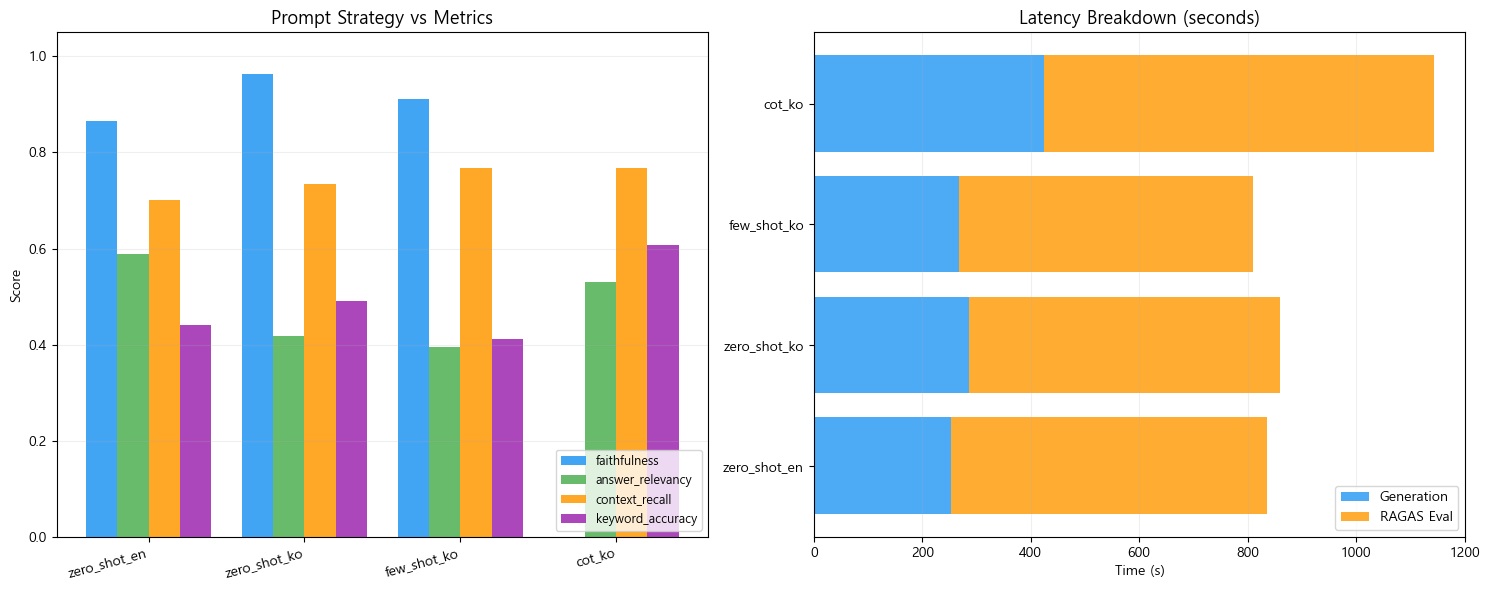


[Details] 상세 결과:
    strategy  faithfulness  answer_relevancy  context_recall  keyword_accuracy  latency_total
zero_shot_en      0.864714          0.589607        0.700000          0.440342     836.040480
zero_shot_ko      0.963237          0.417079        0.733333          0.491620     860.496578
 few_shot_ko      0.911061          0.394030        0.766667          0.411026     809.035629
      cot_ko           NaN          0.531010        0.766667          0.606512    1144.268954

[Best] 최적 프롬프트 전략
  Strategy: zero_shot_ko (한국어 Zero-shot)
  Faithfulness: 0.9632
  Answer Relevancy: 0.4171
  Context Recall: 0.7333
  Keyword Accuracy: 0.4916


In [8]:
df_results = pd.DataFrame([{k: v for k, v in r.items() if k != 'answers'} for r in results])

if not df_results.empty:
    print('=' * 60)
    print('[Result] 실험 결과 요약')
    print('=' * 60)

    # ===== 1. 메트릭 비교 (Grouped Bar Chart) =====
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1-1. 주요 메트릭 비교
    metrics_cols = ['faithfulness', 'answer_relevancy', 'context_recall', 'keyword_accuracy']
    x = np.arange(len(df_results))
    width = 0.2
    colors = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0']

    for i, col in enumerate(metrics_cols):
        axes[0].bar(x + i*width, df_results[col], width,
                    label=col, color=colors[i], alpha=0.85)

    axes[0].set_xticks(x + width * 1.5)
    axes[0].set_xticklabels(df_results['strategy'], rotation=15, ha='right')
    axes[0].set_title('Prompt Strategy vs Metrics', fontsize=13)
    axes[0].set_ylabel('Score')
    axes[0].legend(loc='lower right', fontsize=9)
    axes[0].grid(True, alpha=0.2, axis='y')
    axes[0].set_ylim(0, 1.05)

    # 1-2. Latency 비교
    axes[1].barh(df_results['strategy'], df_results['gen_time'],
                 label='Generation', color='#2196F3', alpha=0.8)
    axes[1].barh(df_results['strategy'], df_results['ragas_time'],
                 left=df_results['gen_time'],
                 label='RAGAS Eval', color='#FF9800', alpha=0.8)
    axes[1].set_title('Latency Breakdown (seconds)', fontsize=13)
    axes[1].set_xlabel('Time (s)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.2, axis='x')

    plt.tight_layout()
    plt.savefig('../data/experiments/exp03_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    # ===== 2. 상세 결과 테이블 =====
    print('\n[Details] 상세 결과:')
    display_cols = ['strategy', 'faithfulness', 'answer_relevancy',
                    'context_recall', 'keyword_accuracy', 'latency_total']
    print(df_results[display_cols].to_string(index=False))

    # ===== 3. 최적 설정 (Faithfulness 우선, 동점 시 Keyword Accuracy) =====
    df_sorted = df_results.sort_values(
        by=['faithfulness', 'keyword_accuracy'], ascending=False
    )
    best_config = df_sorted.iloc[0]

    print('\n' + '=' * 60)
    print('[Best] 최적 프롬프트 전략')
    print('=' * 60)
    print(f'  Strategy: {best_config["strategy"]} ({best_config["description"]})')
    print(f'  Faithfulness: {best_config["faithfulness"]:.4f}')
    print(f'  Answer Relevancy: {best_config["answer_relevancy"]:.4f}')
    print(f'  Context Recall: {best_config["context_recall"]:.4f}')
    print(f'  Keyword Accuracy: {best_config["keyword_accuracy"]:.4f}')

else:
    print('[Warning] 결과가 없습니다.')

## 7. 난이도별 분석 (Difficulty Breakdown)

In [9]:
# 난이도별 Keyword Accuracy 비교
if results:
    print('=' * 60)
    print('[Analysis] 난이도별 Keyword Accuracy')
    print('=' * 60)

    difficulties = [item['difficulty'] for item in pre_retrieved]

    for r in results:
        strategy = r['strategy']
        answers = r['answers']
        gts = [item['ground_truth'] for item in pre_retrieved]

        print(f'\n  [{strategy}]')
        for diff in ['easy', 'medium', 'hard']:
            indices = [i for i, d in enumerate(difficulties) if d == diff]
            if not indices:
                continue
            diff_answers = [answers[i] for i in indices]
            diff_gts = [gts[i] for i in indices]
            acc = calculate_keyword_accuracy(diff_answers, diff_gts)
            print(f'    {diff:>6}: {acc:.4f} ({len(indices)}개)')
else:
    print('[Warning] 결과가 없습니다.')

[Analysis] 난이도별 Keyword Accuracy

  [zero_shot_en]
      easy: 0.4506 (15개)
    medium: 0.4170 (12개)
      hard: 0.4823 (3개)

  [zero_shot_ko]
      easy: 0.4338 (15개)
    medium: 0.5047 (12개)
      hard: 0.7285 (3개)

  [few_shot_ko]
      easy: 0.3650 (15개)
    medium: 0.3991 (12개)
      hard: 0.6888 (3개)

  [cot_ko]
      easy: 0.5639 (15개)
    medium: 0.6002 (12개)
      hard: 0.8447 (3개)


## 8. 결론 및 선정 (Conclusion & Selection)

### 8.1 실험 결과 분석

| Strategy | Faithfulness | Answer Relevancy | Context Recall | Keyword Accuracy |
|----------|-------------|-----------------|----------------|------------------|
| zero_shot_en | 0.8647 | **0.5896** | 0.7000 | 0.4403 |
| **zero_shot_ko** | **0.9632** | 0.4171 | 0.7333 | 0.4916 |
| few_shot_ko | 0.9111 | 0.3940 | 0.7667 | 0.4110 |
| cot_ko | NaN* | 0.5310 | 0.7667 | **0.6065** |

*\*cot_ko의 Faithfulness는 RAGAS TimeoutError로 NaN 발생*

**난이도별 Keyword Accuracy**:

| Strategy | Easy (15) | Medium (12) | Hard (3) |
|----------|-----------|-------------|----------|
| zero_shot_en | 0.4506 | 0.4170 | 0.4823 |
| zero_shot_ko | 0.4338 | 0.5047 | 0.7285 |
| few_shot_ko | 0.3650 | 0.3991 | 0.6888 |
| **cot_ko** | **0.5639** | **0.6002** | **0.8447** |

- **Faithfulness 최고**: `zero_shot_ko` (0.9632) — 한국어 규칙("확인 불가" 응답 유도)이 환각을 효과적으로 억제
- **Keyword Accuracy 최고**: `cot_ko` (0.6065) — 단계별 추론이 정답 키워드 추출에 유리, 특히 Hard 난이도에서 0.8447로 압도적
- **Context Recall**: 모든 전략이 **0.70~0.77 범위에서 정체** — 프롬프트 변경이 검색 품질에 영향을 주지 못함

### 8.2 인사이트 (Findings)

1. **프롬프트는 생성 품질(Faithfulness)은 개선하지만, 검색 품질(Recall)은 개선 불가**
   - Context Recall이 0.70~0.77에서 정체 → 검색 단계에서 필요한 정보의 ~23%를 찾지 못하는 구조적 한계
   - 이 한계는 프롬프트가 아닌 **청킹/인덱싱 전략 개선**으로만 해결 가능
   - → **이 진단이 EXP01-v2(구조 기반 청킹) 실험의 직접적 동기**

2. **한국어 도메인 특화 프롬프트의 효과**
   - 영문(zero_shot_en) 대비 한국어(zero_shot_ko) 프롬프트가 Faithfulness +0.10p 개선 (0.86→0.96)
   - "확인 불가" 규칙이 RFP 문서의 미포함 정보에 대한 환각을 효과적으로 방지
   - 단, Answer Relevancy는 영문이 더 높음 (0.59 vs 0.42) — 한국어 답변의 장문화 경향

3. **CoT는 고난도 질문에서 압도적이나, Faithfulness 측정 불안정**
   - Hard 난이도에서 cot_ko의 Keyword Accuracy(0.8447)가 zero_shot_ko(0.7285)를 크게 상회
   - 그러나 CoT의 장문 출력은 RAGAS Faithfulness 평가 시 TimeoutError 유발
   - 생성 시간도 최대 (424s vs 253~287s) → 프로덕션 사용 시 latency 고려 필요

4. **Few-shot은 기대 이하**
   - few_shot_ko의 Keyword Accuracy(0.4110)가 zero_shot_ko(0.4916)보다 오히려 낮음
   - 2개 예시가 답변 형식을 과도하게 제약하여, 복잡한 질문에 대한 답변 다양성을 억제한 것으로 분석

### 8.3 최종 선정 (Final Decision)

```yaml
Selected Parameters:
  Prompt Strategy: zero_shot_ko (한국어 Zero-shot)
  Faithfulness: 0.9632 (최고)
  Answer Relevancy: 0.4171
  Context Recall: 0.7333
  Keyword Accuracy: 0.4916

Selection Rationale:
  - Faithfulness(환각 방지)를 최우선 메트릭으로 설정 → zero_shot_ko가 최적
  - cot_ko가 Keyword Accuracy 최고이나, Faithfulness NaN + 높은 latency로 제외
  - few_shot_ko는 전반적으로 zero_shot_ko 대비 이점 없음
```

### 8.4 EXP01~03 누적 성과 및 의사결정 흐름

| 실험 | 최적화 대상 | 핵심 결과 | 주요 메트릭 | 의사결정 |
|------|-----------|----------|-----------|---------|
| EXP01 | Chunking | chunk=500, layout | Recall 0.7333 | → 검색 최적화 필요 |
| EXP02 | Retrieval | alpha=0.5, top_k=15 | Recall 0.7667 | → Recall ~0.77 천장 발견 |
| **EXP03** | **Generation** | **zero_shot_ko** | **Faithfulness 0.9632** | → **Recall 천장 미돌파 확인** |

> **EXP03의 핵심 교훈**: 프롬프트 최적화로 생성 품질(Faithfulness 0.96)은 달성했으나, Context Recall ~0.77 천장은 돌파 불가.
> 이 진단을 바탕으로 **V2 실험 라인**을 기획: EXP01-v2에서 T+M(표 통합 + 메타데이터) 청킹으로 Recall **0.7905**(+3.1%)를 달성하여 구조적 한계를 돌파.

### 8.5 적용 계획

- ~~최적 프롬프트를 `RAGChain.prompt`에 반영~~ → V2 라인에서 재평가 필요
- `zero_shot_ko` 전략의 핵심 규칙("확인 불가" 응답, 정량 정보 원문 인용)은 V2 프롬프트 설계 시에도 유지
- CoT 전략은 Hard 난이도 질문 전용 옵션으로 검토 가능 (Faithfulness 안정화 후)
- **EXP03-v2**: T+M 컨텍스트 환경에서 프롬프트 전략을 재평가하면 생성 품질이 추가 개선될 가능성 있음

## 9. 리포트 저장 (Save Report)

In [10]:
from datetime import datetime

if results:
    report_path = '../data/experiments/exp03_report.json'
    csv_path = '../data/experiments/exp03_results.csv'

    # Best config 추출 (answers 제외)
    df_sorted = df_results.sort_values(
        by=['faithfulness', 'keyword_accuracy'], ascending=False
    )
    best = df_sorted.iloc[0].to_dict()

    report = {
        'meta': {
            'experiment': 'Exp-03 Prompt Engineering',
            'version': 'v1',
            'date': datetime.now().isoformat(),
            'sample_file': SAMPLE_FILE,
            'num_test_cases': len(golden_df),
            'prerequisite': {
                'chunk_size': CHUNK_SIZE,
                'table_strategy': TABLE_STRATEGY,
                'alpha': ALPHA,
                'top_k': TOP_K,
                'exp02_context_recall': EXP02_RECALL,
            }
        },
        'best_config': {
            'strategy': best['strategy'],
            'description': best['description'],
            'faithfulness': float(best['faithfulness']),
            'answer_relevancy': float(best['answer_relevancy']),
            'context_recall': float(best['context_recall']),
            'keyword_accuracy': float(best['keyword_accuracy']),
        },
        'strategies': list(PROMPT_STRATEGIES.keys()),
        'results': [{k: v for k, v in r.items() if k != 'answers'} for r in results],
    }

    with open(report_path, 'w', encoding='utf-8') as f:
        json.dump(report, f, indent=2, ensure_ascii=False)
    print(f'[Saved] Report: {report_path}')

    df_results.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f'[Saved] CSV: {csv_path}')

    print('\n' + '=' * 60)
    print('[Summary] EXP03 완료')
    print('=' * 60)
    print(f'  Best Strategy: {best["strategy"]} ({best["description"]})')
    print(f'  Faithfulness: {best["faithfulness"]:.4f}')
    print(f'  Answer Relevancy: {best["answer_relevancy"]:.4f}')
    print(f'  Keyword Accuracy: {best["keyword_accuracy"]:.4f}')
    print(f'\n  -> RAGChain 프롬프트 및 extraction/prompts에 적용하세요.')
else:
    print('[Warning] 저장할 결과가 없습니다.')

[Saved] Report: ../data/experiments/exp03_report.json
[Saved] CSV: ../data/experiments/exp03_results.csv

[Summary] EXP03 완료
  Best Strategy: zero_shot_ko (한국어 Zero-shot)
  Faithfulness: 0.9632
  Answer Relevancy: 0.4171
  Keyword Accuracy: 0.4916

  -> RAGChain 프롬프트 및 extraction/prompts에 적용하세요.
